# Subtask 2
# Density-based clustering

Requirements:

- Python 3.13.1
- numpy
- pandas
- scikit-learn
- matplotlib

In [1]:
import logging
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
import gower
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## Preprocessing
Load the data and preprocess it. Drop features we dont need. Since we are working with mixed-type data, we need to encode features that are not continuous numeric. Also, missing values need to be imputated.

In [2]:
df = pd.read_csv("../dataset/tracks.csv")
df.head()

,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",False
3,TR480968,ART04205421,Rosa Chemical,CEO by Rosa Chemical (Ft. Taxi B),CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,39890.0,...,single,1.0,2.0,169000.0,True,47.0,https://i.scdn.co/image/ab67616d0000b27367c03d...,ALB730959,Designer sui vestiti penso di essere un outlet...,False
4,TR585039,ART04205421,Rosa Chemical,LONDRA by Rosa Chemical (Ft. Rkomi),LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,35432.0,...,album,1.0,8.0,194779.0,True,41.0,https://i.scdn.co/image/ab67616d0000b273fcdb60...,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",False


### Drop Irrelevant Features
Many columns such as names or unique identifiers are not relevant for clustering. We drop them.

In [3]:
cols_to_drop = ["id",
    "id_artist",
    "name_artist",
    "full_title",
    "title",
    "album_name",
    "album_release_date",
    "id_album",
    "album_image",
    "lyrics",
    "swear_IT_words",
    "swear_EN_words",
    "month",
    "day",
    "disc_number",
    "track_number"
]

df = df.drop(columns=cols_to_drop)

In [4]:
# Relevant preprocessing functions

def clean(df: pd.DataFrame) -> pd.DataFrame:
    # Replace empty cells (or ?) with NA
    df = df.replace(r"^\?|\s+$", pd.NA, regex=True)

    # Columns with whitespace (or ?) values are infered as string type but could be numeric
    for col in df.select_dtypes(exclude=[np.number, np.bool_]).columns:
        # Exclude booleans
        if df[col].nunique() > 2:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                logging.debug("Could not convert column %s to numeric dtype", col)

    # Integer columns with missing values automatically get converted to float columns
    # We want to convert back to integer to allow for better column classification (num/cat)
    for col in df.select_dtypes(include=np.floating):
        if np.all(df[col].fillna(0) % 1 == 0):
            df[col] = df[col].astype("Int64")

    # Turn object columns into string columns (causes issues with stepmix)
    for col in df.select_dtypes(include=object).columns:
        df[col] = df[col].astype(str)

    return df


def classify_cols(
    df: pd.DataFrame,
    bool_cols: bool = False,
) -> Tuple:
    # All floating point columns are considered numeric
    num_cols: List[str] = list(df.select_dtypes(include=np.inexact).columns)
    cat_cols: List[str] = []
    bool_cols_: List[str] = list(df.select_dtypes(include=np.bool_).columns) if bool_cols else []

    remaining_cols = df.columns.difference(num_cols + bool_cols_)

    if bool_cols:
        for col in remaining_cols:
            if df[col].nunique() <= 2:
                bool_cols_.append(col)
                remaining_cols = remaining_cols.drop(col)

    # Integer columns with more than 50 unique values are considered numeric
    for col in df[remaining_cols].select_dtypes(include=np.integer).columns:
        if df[col].nunique() >= 50:
            num_cols.append(col)
            remaining_cols = remaining_cols.drop(col)

    # All other columns are considered categorical
    cat_cols = list(remaining_cols)

    logging.info("Num cols: %s", num_cols)
    logging.info("Cat cols: %s", cat_cols)
    logging.info("Bool cols: %s", bool_cols_)
    if bool_cols:
        return num_cols, cat_cols, bool_cols_
    return num_cols, cat_cols


def scale_cols(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if num_cols:
        df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    if bool_cols:
        df[bool_cols] = df[bool_cols].apply(LabelEncoder().fit_transform)
    return df


def imputate_na(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    if num_cols:
        # imputate numeric features
        for col in num_cols:
            df[col] = df[col].fillna(round(df[col].median()))
    if cat_cols is None:
        cat_cols = []
    if bool_cols is None:
        bool_cols = []
    # add "missing" category for categorical features
    for col in cat_cols + bool_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].fillna("<NA>")
    return df

### Cleaning, Imputating, Scaling and Labelling
Now execute the functions from above to return a dataframe we can use for computation.

In [5]:
# Save old dataframe for later
og_df = df.copy(deep=True)

df = clean(df)
num_cols, cat_cols, bool_cols = classify_cols(df, bool_cols=True)
df = imputate_na(df, num_cols, cat_cols, bool_cols)
df = scale_cols(df, num_cols, cat_cols, bool_cols)

df.head()

,featured_artists,primary_artist,language,album,stats_pageviews,swear_IT,swear_EN,year,n_sentences,n_tokens,...,zcr,flatness,spectral_complexity,pitch,loudness,album_type,duration_ms,explicit,popularity,modified_popularity
0,485,82,24,240,4.382687,5,34,104,1.730216,1.986653,...,2.245231,-0.371348,-0.201151,0.144966,-0.737947,0,0.048662,1,82,0
1,1579,82,9,240,3.566031,43,4,103,-0.137659,0.854572,...,2.940790,-1.709861,0.202091,-0.954668,-0.321424,0,0.048662,1,82,0
2,1004,82,9,240,0.821598,8,4,104,1.161733,1.252719,...,0.918816,-0.700716,-0.051288,0.599459,0.606187,0,-0.112995,1,72,0
3,1555,82,17,555,0.345227,42,21,102,-0.909173,-0.550936,...,-1.043848,0.142831,-1.557827,1.912401,-0.431909,3,-0.392077,1,83,0
4,1382,82,9,240,0.229954,1,0,103,-0.462507,-0.325479,...,0.352663,-0.033747,1.103381,-1.794887,0.128634,0,-0.098952,1,75,0


### Gower Distance Matrix
Since we're working with mixed-type data (numeric, categorical, and boolean), we'll use Gower distance instead of Euclidean distance. Gower distance is specifically designed to handle mixed-type data by computing appropriate distances for each data type and then combining them.

For Gower distance, we don't need one-hot encoding - it handles categorical variables directly.

In [6]:
# Compute Gower distance matrix
# Note: Gower distance works with the original scaled data, not one-hot encoded
print("Computing Gower distance matrix... This may take a while for large datasets.")
gower_dist_matrix = gower.gower_matrix(df)
print(f"Gower distance matrix shape: {gower_dist_matrix.shape}")

# For compatibility with sklearn metrics, we'll keep the encoded_df for feature importance calculation
# but use gower distances for clustering
encoded_df = df.copy(deep=True)

Computing Gower distance matrix... This may take a while for large datasets.
Gower distance matrix shape: (11166, 11166)


## Clustering
We can now cluster the songs using DBSCAN (Density-Based Spatial Clustering of Applications with Noise).
DBSCAN groups together points that are closely packed together, marking points that lie alone in low-density regions as outliers (noise). The key parameters are:
- **eps**: The maximum distance between two samples for them to be considered in the same neighborhood
- **min_samples**: The minimum number of samples in a neighborhood for a point to be considered a core point

### Evaluation
Similar to k-means, we need to find the optimal values for these hyperparameters. We do it similarly, using similar evaluation criterions:
- **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters (higher is better)
- **Variance Ratio Criterion (Calinski-Harabasz)**: Ratio of between-cluster to within-cluster variance (higher is better)
- **Davies-Bouldin Index**: Average similarity between clusters (lower is better)
- **Number of Clusters**: Total clusters found (excluding noise)
- **Noise Points**: Number of points classified as noise (-1 label)
SSE is omitted here since DBSCAN is not a centroid-based clustering approach.

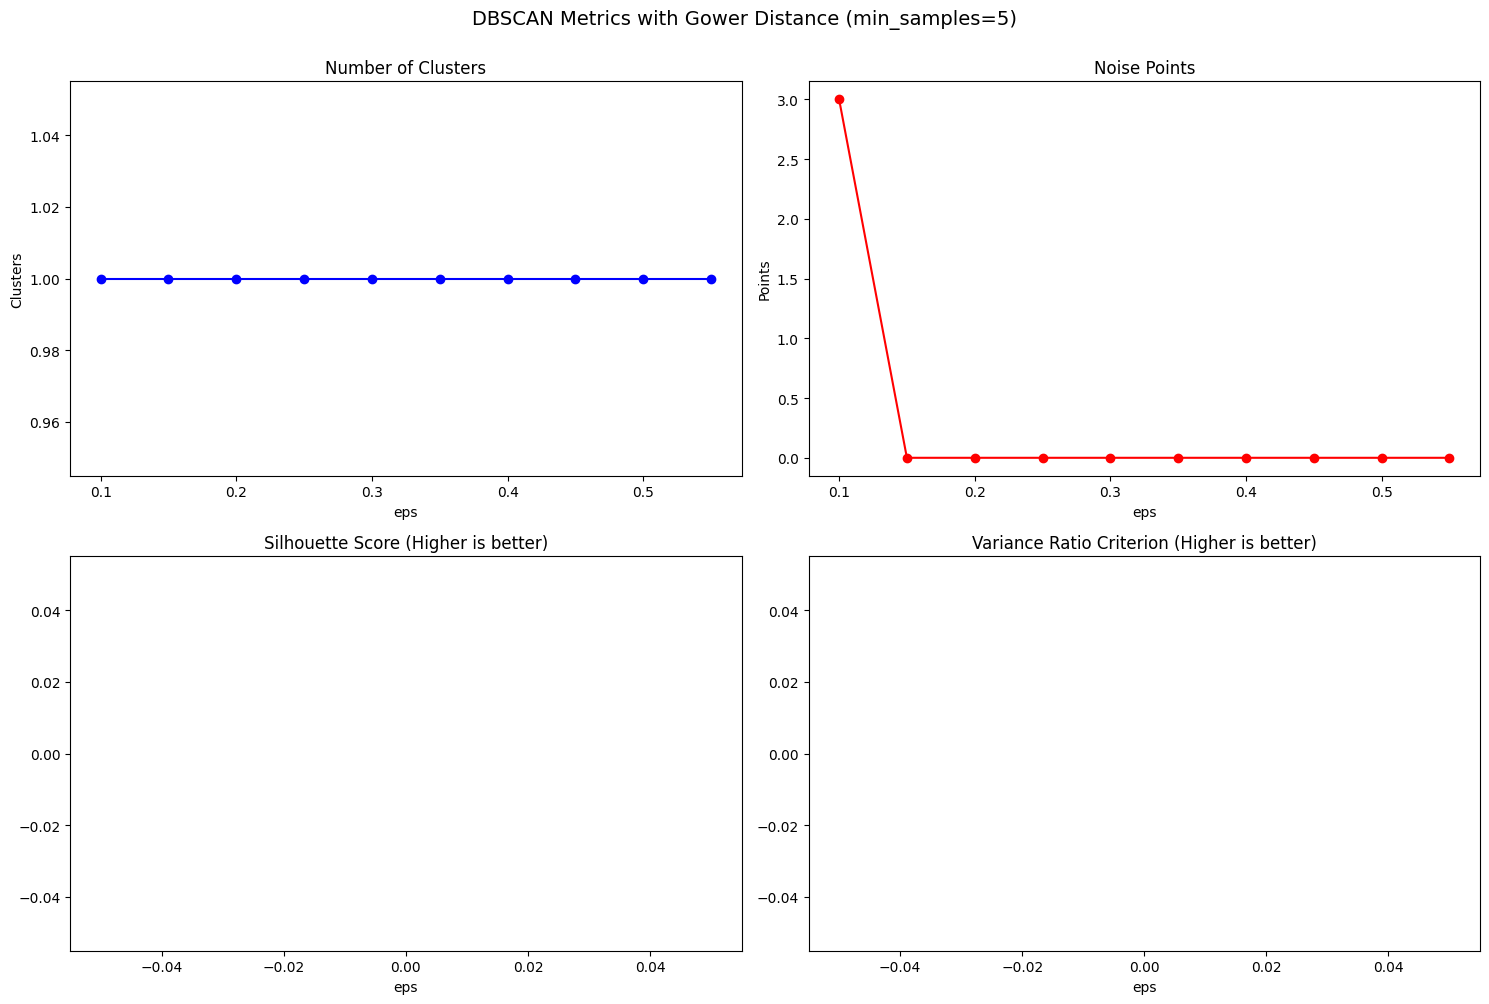

In [7]:
# DBSCAN with different eps values using Gower distance
dbscan_results = {}
dbscan_metrics = {
    'eps': [],
    'n_clusters': [],
    'n_noise': [],
    'silhouette': [],
    'vrc': [],
    'davies_bouldin': []
}

eps_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
min_samples = 5

for eps in eps_values:
    # Use metric='precomputed' to use our Gower distance matrix
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(gower_dist_matrix)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    dbscan_results[eps] = labels
    dbscan_metrics['eps'].append(eps)
    dbscan_metrics['n_clusters'].append(n_clusters)
    dbscan_metrics['n_noise'].append(n_noise)
    
    # Only calculate metrics if we have at least 2 clusters and not all points are noise
    if n_clusters >= 2 and n_noise < len(labels):
        # Filter out noise points for metric calculation
        mask = labels != -1
        if mask.sum() > 0:
            # Use Gower distance matrix for silhouette score
            dbscan_metrics['silhouette'].append(silhouette_score(gower_dist_matrix[mask][:, mask], labels[mask], metric='precomputed'))
            dbscan_metrics['vrc'].append(calinski_harabasz_score(df.values[mask], labels[mask]))
            dbscan_metrics['davies_bouldin'].append(davies_bouldin_score(df.values[mask], labels[mask]))
        else:
            dbscan_metrics['silhouette'].append(np.nan)
            dbscan_metrics['vrc'].append(np.nan)
            dbscan_metrics['davies_bouldin'].append(np.nan)
    else:
        dbscan_metrics['silhouette'].append(np.nan)
        dbscan_metrics['vrc'].append(np.nan)
        dbscan_metrics['davies_bouldin'].append(np.nan)

# Plot DBSCAN metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(dbscan_metrics['eps'], dbscan_metrics['n_clusters'], 'bo-')
axes[0,0].set_title('Number of Clusters')
axes[0,0].set_xlabel('eps')
axes[0,0].set_ylabel('Clusters')

axes[0,1].plot(dbscan_metrics['eps'], dbscan_metrics['n_noise'], 'ro-')
axes[0,1].set_title('Noise Points')
axes[0,1].set_xlabel('eps')
axes[0,1].set_ylabel('Points')

axes[1,0].plot(dbscan_metrics['eps'], dbscan_metrics['silhouette'], 'go-')
axes[1,0].set_title('Silhouette Score (Higher is better)')
axes[1,0].set_xlabel('eps')

axes[1,1].plot(dbscan_metrics['eps'], dbscan_metrics['vrc'], 'mo-')
axes[1,1].set_title('Variance Ratio Criterion (Higher is better)')
axes[1,1].set_xlabel('eps')

plt.suptitle(f'DBSCAN Metrics with Gower Distance (min_samples={min_samples})', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## Evaluation
### Cluster Overview
What do we do with the clusters now? What we can do is to look into each cluster and look into the average variables that it has. We create a table that has a row for each cluster and a column for each variable. The value in the cell is the rounded average of that variable for that cluster. In case of categorical variables, the most common category is listed with its percentage in braces. For boolean variables, both options are listed with their percentages. The columns (features) are sorted by their importance towards the clustering process, more on that in the next section.

Note: Noise points (labeled as -1) are shown separately.

In [9]:
def cluster_overview(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    num_cols: List[str],
    cat_cols: List[str],
    bool_cols: List[str],
    feature_importances: Dict[str, float],
) -> pd.DataFrame:
    def num_agg(series):
        res = f"~{series.mean():.2f}"
        if res == "~-0.0":
            return "~0.0"
        return res

    def cat_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) >= 1:
            return f"{vc.index[0]} ({vc.iloc[0]:.0%})"
        else:
            return "NA (100%)"

    def bool_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) == 1:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}"
        elif len(vc) == 2:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}/{vc.iloc[1]:.0%} {vc.index[1]}"
        else:
            return "100% NA"

    df = original_df.copy(deep=True)
    df["Cluster ID"] = cluster_labels
    
    # Get unique cluster IDs (including -1 for noise if present)
    unique_clusters = sorted(np.unique(cluster_labels))
    
    # Calculate per-cluster aggregations
    df_clusters = pd.concat(
        [
            df[num_cols + ["Cluster ID"]].groupby("Cluster ID").agg(num_agg) if num_cols else pd.DataFrame(),
            df[cat_cols + ["Cluster ID"]].groupby("Cluster ID").agg(cat_agg) if cat_cols else pd.DataFrame(),
            df[bool_cols + ["Cluster ID"]].groupby("Cluster ID").agg(bool_agg) if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_clusters = df_clusters.reset_index()
    
    # Calculate overall aggregations for entire dataset
    df_overall = pd.concat(
        [
            df[num_cols].agg(num_agg).to_frame().T if num_cols else pd.DataFrame(),
            df[cat_cols].agg(cat_agg).to_frame().T if cat_cols else pd.DataFrame(),
            df[bool_cols].agg(bool_agg).to_frame().T if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_overall["Cluster ID"] = "All Clusters"
    
    # Add member counts
    counts = np.bincount(cluster_labels[cluster_labels >= 0])  # Only count non-noise
    noise_count = (cluster_labels == -1).sum()
    
    df_clusters["Members"] = df_clusters.apply(
        lambda row: noise_count if row["Cluster ID"] == -1 else counts[int(row["Cluster ID"])], 
        axis=1
    )
    df_overall["Members"] = len(cluster_labels)
    
    # Format cluster IDs
    df_clusters["Cluster ID"] = df_clusters["Cluster ID"].apply(
        lambda x: "Noise" if x == -1 else f"Cluster {x}"
    )
    
    # Combine cluster data with overall data
    df_result = pd.concat([df_clusters, df_overall], ignore_index=True)
    
    # Order features by importance
    df_result = df_result[["Cluster ID", "Members"] + list(feature_importances.keys())]

    return df_result


def feature_importances(
    df: pd.DataFrame,
    labels: np.ndarray
) -> Dict[str, float]:
    # Filter out noise points for feature importance calculation
    mask = labels != -1
    if mask.sum() == 0:
        return {}
    
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(df[mask], labels[mask])
    return dict(
        sorted(
            zip(df.columns, classifier.feature_importances_),
            key=lambda it: it[1],
            reverse=True,
        )
    )


chosen_eps = 0.3
labels = dbscan_results[chosen_eps]

feature_importances_dict = feature_importances(df, labels)
cluster_overview(og_df, labels, num_cols, cat_cols, bool_cols, feature_importances_dict)

,Cluster ID,Members,featured_artists,primary_artist,language,album,stats_pageviews,swear_IT,swear_EN,year,...,zcr,flatness,spectral_complexity,pitch,loudness,album_type,duration_ms,explicit,popularity,modified_popularity
0,Cluster 0,11166,Guè (2%),Mondo Marcio (3%),it (85%),Rimo Da Quando (0%),~36993.65,0 (37%),0 (75%),2021.0 (6%),...,~0.06,~0.86,~27.41,~2256.03,~24.23,album (84%),~203529.27,True (51%),34.0 (2%),99% False/1% True
1,All Clusters,11166,Guè (2%),Mondo Marcio (3%),it (85%),Rimo Da Quando (0%),~36993.65,0 (37%),0 (75%),2021.0 (6%),...,~0.06,~0.86,~27.41,~2256.03,~24.23,album (84%),~203529.27,True (51%),34.0 (2%),99% False/1% True


### Feature Importances
The feature importance was already used above to sort the columns of the cluster overview table descending by their importance towards the clustering process. We can also plot it as a bar chart to get a better undestanding of the feature that contributed most to the separation of the clusters. 

We cannot directly extract the feature importance from the density-based clustering model, but instead we can approximate the feature importances by training a supervised model on the cluster labels we generated. Some sort of decision tree models works well because of their explainability, which allows us to calculate the feature importances. We use a Random Forest Classifier here.

Note: Noise points are excluded from the feature importance calculation.

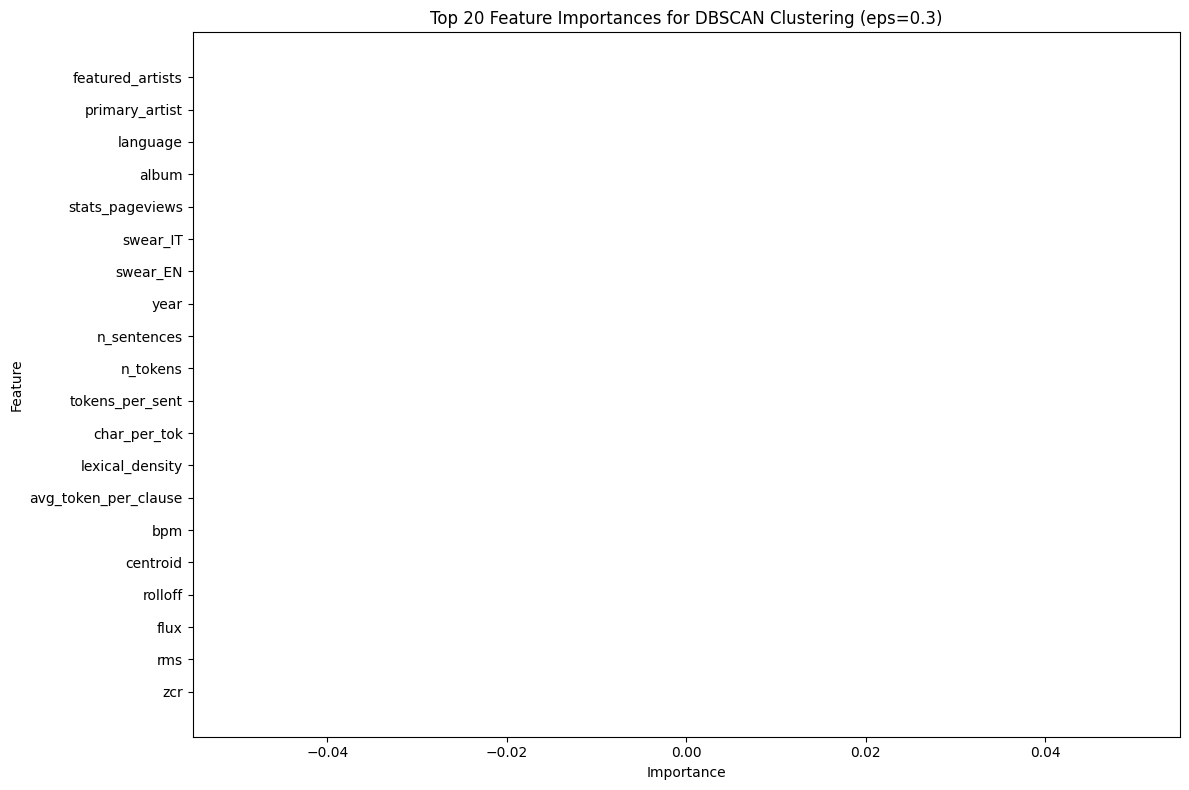

In [10]:
top_n = 20
top_features = list(feature_importances_dict.items())[:top_n]
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, color='steelblue')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances for DBSCAN Clustering (eps={chosen_eps})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Artists per Cluster
To validate whether the clustering makes sense, we can examine which artists belong to each cluster. This allows us to listen to the artists and verify if the clusters have meaningful musical or stylistic coherence.

Note: Noise points are shown separately.

In [11]:
def get_artists_per_cluster(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    artist_column: str = 'name_artist',
    top_n: int = 10
) -> pd.DataFrame:
    original_df['cluster'] = cluster_labels
    
    cluster_data = {}
    unique_clusters = sorted(np.unique(cluster_labels))
    
    for cluster_id in unique_clusters:
        cluster_df = original_df[original_df['cluster'] == cluster_id]
        
        # Count tracks per artist in this cluster
        artist_counts = cluster_df[artist_column].value_counts().head(top_n)
        
        # Format as "Artist (N tracks)"
        formatted_artists = [f"{artist} ({count})" for artist, count in zip(artist_counts.index, artist_counts.values)]
        
        # Pad with empty strings if less than top_n artists
        while len(formatted_artists) < top_n:
            formatted_artists.append("")
        
        cluster_name = "Noise" if cluster_id == -1 else f'Cluster {cluster_id}'
        cluster_data[cluster_name] = formatted_artists
    
    df = pd.DataFrame(cluster_data)
    return df


full_og_df = pd.read_csv('../dataset/tracks.csv')
artists_df = get_artists_per_cluster(full_og_df, labels, top_n=10)
artists_df

,Cluster 0
0,Mondo Marcio (353)
1,Gemitaiz (333)
2,Guè (333)
3,Bassi Maestro (279)
4,Fabri Fibra (275)
5,Vacca (274)
6,Emis Killa (237)
7,Achille Lauro (194)
8,Lazza (187)
9,Salmo (186)
